# IHT20H DS Test Task

## Set up

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [89]:
import sklearn 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

In [90]:
plt.rcParams.update({"figure.figsize": (20, 6)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Preprocessing

In [91]:
events = pd.read_csv('int20h-ds-test-dataset.csv')

In [92]:
events['event_created_date'] = pd.to_datetime(events['event_created_date'])
events['ts'] = events['event_created_date'].values.astype(int) // 10 ** 9

In [93]:
events.head(5)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model,ts
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U,1642352584
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U,1642352867
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1,1642353385
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U,1642353862
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1",1642354491


**Треба описати, що ми розуміємо про дані:**
1. Що це дані тільки за три місяці, тому премуім юзери не тільки ті, в яких є івент підписки. Тому треба окремо думати про те, як зрозуміти, в кого є підписка
1. Передбачувати івент скасування підписки має сенс тільки на тих юзерах, в яких вона в принципі була

In [94]:
device_manufacture = dict(events[['device_model', 'device_manufacture']].values)
device_platform = dict(events[['device_model', 'event_platform']].values)

In [95]:
def nth_unique(n=1):
    def _nth_unique(x):
        uniq = list(set(x[x.notna()]))
        return uniq[n-1] if len(uniq) > n-1 else "None"
    return _nth_unique
    
users_info = events[['userid', 'user_state', 'device_model', 'event_name', 'ts']].groupby('userid').agg(
    user_state=pd.NamedAgg("user_state", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    device1=pd.NamedAgg("device_model", nth_unique(n=1)),
    device2=pd.NamedAgg("device_model", nth_unique(n=2)),
    device3=pd.NamedAgg("device_model", nth_unique(n=3)),
    most_popular_event=pd.NamedAgg("event_name", lambda x: pd.Series.mode(x)[0] if pd.Series.mode(x)[0] != "Subscription Premium Cancel" else "None"),
    most_popular_device=pd.NamedAgg("device_model", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    num_devices_and_nans=pd.NamedAgg("device_model", lambda x: len(pd.Series.unique(x))),
    last_event_ts=pd.NamedAgg("ts", pd.Series.max)
)

In [96]:
users_info['last_order_ts'] = events.loc[events['event_name'] == 'Order', ['userid', 'ts']].groupby('userid').max()['ts']

In [97]:
for i in range(1, 4):
    users_info[f'device{i}_manufacture'] = users_info[f'device{i}'].map(device_manufacture)
    users_info[f'device{i}_platform'] = users_info[f'device{i}'].map(device_platform)

In [98]:
users_info = users_info.astype(dtype={
   col : "category" for col in users_info.columns
})

In [99]:
users_events = events[['userid', 'event_name']].groupby(['userid', 'event_name']).agg(
    count_col=pd.NamedAgg(column="event_name", aggfunc='count'),
)
users_events = users_events.unstack(fill_value=0)
users_events.columns = [col[1] for col in users_events.columns]
# users_events['Events number'] = users_events.sum(axis=1)

In [100]:
users=users_events.join(users_info) 

In [101]:
# users['Orders_fraction'] = users['Order'] / users['Events number']

In [102]:
users_premium = users[(users['Subscription Premium'] > 0) | 
                      (users['Subscription Premium Renew'] > 0) |
                      (users['Subscription Premium Cancel'] > 0)]

In [103]:
users_premium

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans,last_event_ts,last_order_ts,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,MD,SM-A716U,None,None,Account History Transaction Details,SM-A716U,2,1645233136,NaN,samsung,android,NaN,NaN,NaN,NaN
00596aa4edee32815aaf4aad659c484e,0,0,0,0,2,0,0,1,0,0,0,0,0,3,0,0,0,1,1,0,0,0,0,CA,SM-N976U,None,None,Order,SM-N976U,2,1646491529,1.646492e+09,samsung,android,NaN,NaN,NaN,NaN
007b54670d72df309afd87befcbb63db,0,0,0,0,1,1,0,1,0,0,4,1,0,0,0,0,0,1,1,0,0,0,0,CA,"iPhone13,4",None,None,Chat Conversation Opened,"iPhone13,4",2,1649255007,NaN,Apple,ios,NaN,NaN,NaN,NaN
0136a8eeca5d16ac1a521dd0e27ecec0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,2,0,0,TX,"iPhone12,1",None,None,Subscription Premium Renew,"iPhone12,1",2,1647565945,NaN,Apple,ios,NaN,NaN,NaN,NaN
01529f53aaba5b512168d432d5650556,2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,IL,moto g play (2021),None,None,Account History Transaction Details,moto g play (2021),2,1649875208,NaN,motorola,android,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fc9b74bab85fdc6cbdb5b965ca9f760f,1,0,0,0,1,0,0,1,0,0,4,1,0,0,0,0,0,1,1,2,0,0,1,CA,"iPhone12,1",None,None,Chat Conversation Opened,"iPhone12,1",2,1648472960,NaN,Apple,ios,NaN,NaN,NaN,NaN
fd422ac5f5772dc211a97910ea880db2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,CA,"iPhone14,3",None,None,Add Payment Method Success,"iPhone14,3",2,1648412086,NaN,Apple,ios,NaN,NaN,NaN,NaN
fd4a11b9abba7352308fabf80c122501,0,0,0,0,1,2,0,5,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,CA,"iPhone12,1","iPhone12,5",None,Add Vehicle Success,"iPhone12,5",3,1648607307,NaN,Apple,ios,Apple,ios,NaN,NaN


## Classification

In [170]:
X = users_premium.drop(columns=["Subscription Premium Cancel"])
y = (users_premium["Subscription Premium Cancel"] > 0).values

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [173]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

In [174]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## Features importance

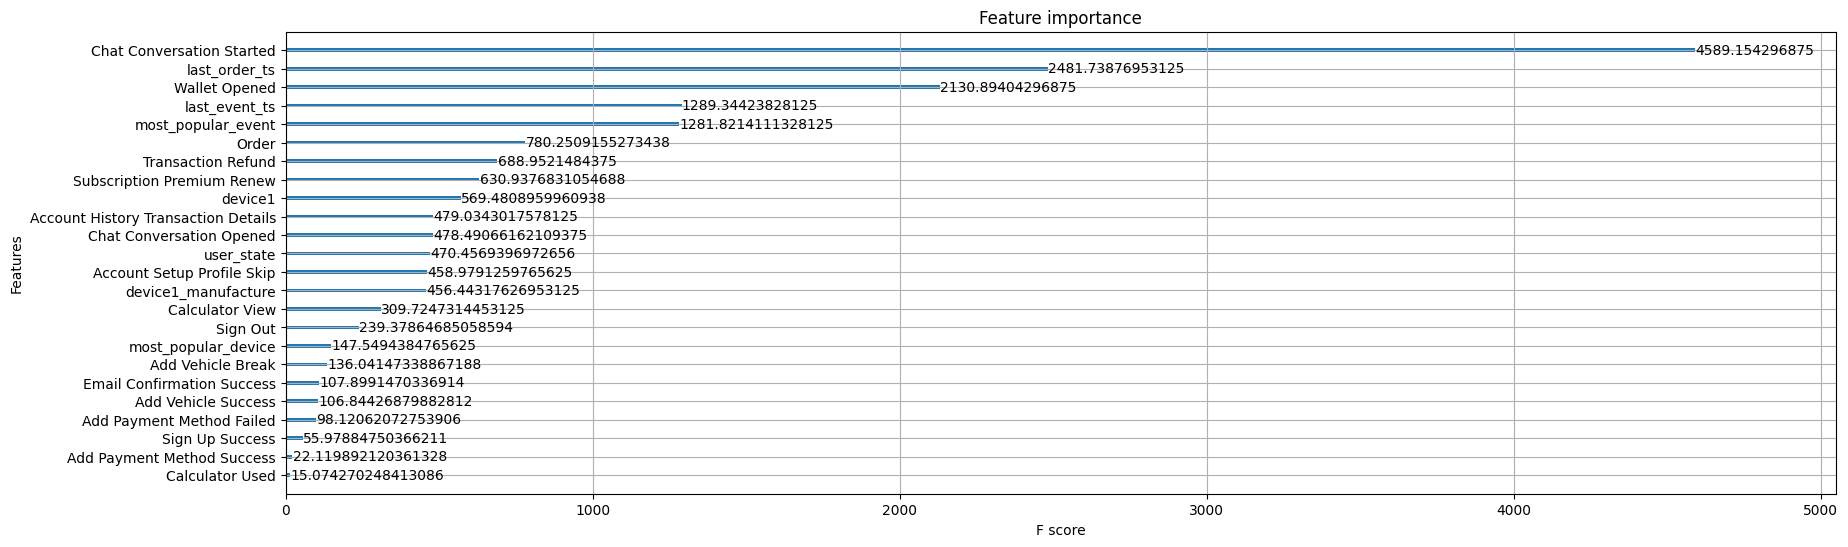

In [175]:
xgb.plot_importance(model, importance_type="total_cover")
plt.show()

In [176]:
model.feature_importances_

array([0.01080171, 0.02833352, 0.        , 0.0484659 , 0.00570578,
       0.01562854, 0.        , 0.02402766, 0.01446761, 0.0116408 ,
       0.02401971, 0.3097194 , 0.01858802, 0.01894369, 0.        ,
       0.02670495, 0.        , 0.03660794, 0.        , 0.03178316,
       0.16257508, 0.03685364, 0.01735032, 0.02453388, 0.        ,
       0.        , 0.04674183, 0.04251124, 0.        , 0.0185955 ,
       0.01125022, 0.01414992, 0.        , 0.        , 0.        ,
       0.        , 0.        ], dtype=float32)

In [177]:
y_test_pred = model.predict(X_test)

In [178]:
round(accuracy_score(y_test, y_test_pred), 2)

0.75

In [179]:
precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.5643564356435643, 0.9047619047619048)

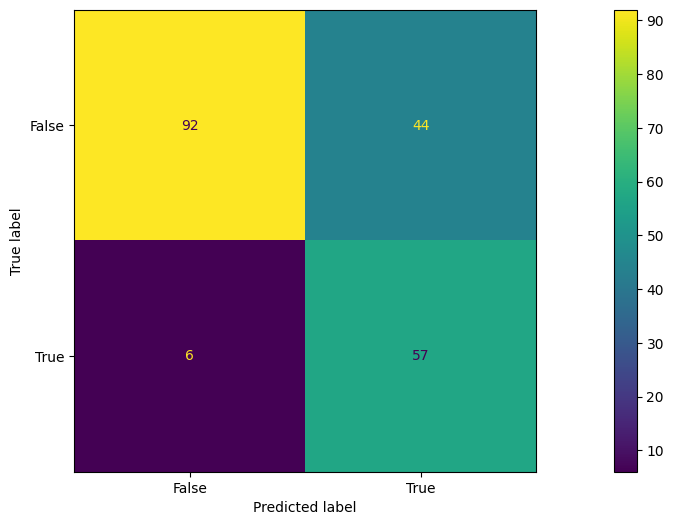

In [180]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)